In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [ ]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
dataset = 'cassins_dtw'
dims = (32,32,1)

In [6]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

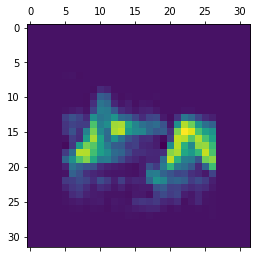

In [7]:
syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')

#syllable_df= syllable_df[:1000]

syllable_df[:3]

top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)
top_labels

syllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]

syllable_df[:3]

syllable_df = syllable_df.reset_index()

syllable_df['subset'] = 'train'
syllable_df.loc[:1000, 'subset'] = 'valid'
syllable_df.loc[1000:1999, 'subset'] = 'test'
#syllable_df.loc[:100, 'subset'] = 'valid'
#syllable_df.loc[100:199, 'subset'] = 'test'

specs = np.array(list(syllable_df.spectrogram.values))
specs = np.array([np.concatenate([np.zeros((32,1)), i], axis=1) for i in tqdm(specs)])
specs.shape

syllable_df['spectrogram'] = syllable_df['spectrogram'].astype('object')
syllable_df['spectrogram'] = list(specs)

np.shape(syllable_df['spectrogram'].values[0])

len(syllable_df)

Y_train = np.array(list(syllable_df.labels.values[syllable_df.subset == 'train']))
Y_valid = np.array(list(syllable_df.labels.values[syllable_df.subset == 'valid']))
Y_test = np.array(list(syllable_df.labels.values[syllable_df.subset == 'test']))

X_train = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'test'])) #/ 255.

X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).astype('int').flatten()
plt.matshow(X_train[10])

### Create model and train

In [8]:
from tensorflow.keras.layers import (
    Conv2D,
    Reshape,
    Bidirectional,
    Dense,
    RepeatVector,
    TimeDistributed,
    LSTM
)
n_components=2

#shape_final = (8,2,128)

encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    ),
    Reshape(target_shape=(8, 2*128)),
    Bidirectional(LSTM(units=100, activation="relu")),
    Dense(units=512),
    Dense(units=n_components),
])

In [9]:
batch_size = 5000

In [10]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [11]:
from tfumap.parametric_tsne import compute_joint_probabilities, tsne_loss

In [12]:
save_loc = DATA_DIR/ 'parametric_tsne'/ dataset / 'P.npy'
if save_loc.exists():
    P = np.load(save_loc)
else:
    P = compute_joint_probabilities(X_train_flat, batch_size=batch_size, perplexity=30, verbose=2)
    ensure_dir(save_loc)
    np.save(save_loc, P)

In [13]:
X_train_subset = X_train[:np.product(P.shape[:2])]

In [14]:
# Joint probabilities of data
Y_train_tsne = P.reshape(X_train_subset.shape[0], -1)

In [15]:
X_train.shape[0]

24984

In [16]:
opt = tf.keras.optimizers.Adam(lr=0.01)

In [17]:
n_components = 2
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(
    tf.keras.layers.Dense(units=n_components, name="z")
)

In [18]:
encoder.compile(loss=tsne_loss(d=n_components, batch_size=batch_size), optimizer=opt)

In [19]:
X_train_subset = np.reshape(X_train_subset, ([len(X_train_subset)]+ list(dims)))
X_test = np.reshape(X_test, ([len(X_test)]+ list(dims)))

In [20]:
# because shuffle == False, the same batches are used each time...
history = encoder.fit(X_train_subset, Y_train_tsne, batch_size=batch_size, shuffle=False, nb_epoch=1000)

W0720 10:46:50.487079 139722737252160 training.py:792] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 20000 samples
Epoch 1/1000
20000/20000 [==============================] - 6s 301us/sample - loss: 4.0944
Epoch 2/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 2.8208
Epoch 3/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 2.6649
Epoch 4/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 2.6119
Epoch 5/1000
20000/20000 [==============================] - 0s 10us/sample - loss: 2.4875
Epoch 6/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 2.3809
Epoch 7/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 2.3049
Epoch 8/1000
20000/20000 [==============================] - 0s 10us/sample - loss: 2.2179
Epoch 9/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 2.1526
Epoch 10/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 2.0888
Epoch 11/1000
20000/20000 [==============================] - 0s 11us/sample

20000/20000 [==============================] - 0s 22us/sample - loss: 1.2558
Epoch 91/1000
20000/20000 [==============================] - 0s 20us/sample - loss: 1.2536
Epoch 92/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.2559
Epoch 93/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.2440
Epoch 94/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.2442
Epoch 95/1000
20000/20000 [==============================] - 0s 19us/sample - loss: 1.2374
Epoch 96/1000
20000/20000 [==============================] - 0s 20us/sample - loss: 1.2331
Epoch 97/1000
20000/20000 [==============================] - 0s 24us/sample - loss: 1.2336
Epoch 98/1000
20000/20000 [==============================] - 0s 14us/sample - loss: 1.2285
Epoch 99/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.2263
Epoch 100/1000
20000/20000 [==============================] - 0s 22us/sample - loss: 1.2205
Epoch 101/10

20000/20000 [==============================] - 0s 13us/sample - loss: 1.1561
Epoch 180/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.1489
Epoch 181/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.1458
Epoch 182/1000
20000/20000 [==============================] - 0s 21us/sample - loss: 1.1500
Epoch 183/1000
20000/20000 [==============================] - 0s 22us/sample - loss: 1.1563
Epoch 184/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.1525
Epoch 185/1000
20000/20000 [==============================] - 0s 13us/sample - loss: 1.1471
Epoch 186/1000
20000/20000 [==============================] - 0s 13us/sample - loss: 1.1499
Epoch 187/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.1466
Epoch 188/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.1452
Epoch 189/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.1490
Epo

20000/20000 [==============================] - 0s 11us/sample - loss: 1.1080
Epoch 269/1000
20000/20000 [==============================] - 0s 16us/sample - loss: 1.1090
Epoch 270/1000
20000/20000 [==============================] - 0s 20us/sample - loss: 1.1044
Epoch 271/1000
20000/20000 [==============================] - 1s 26us/sample - loss: 1.1105
Epoch 272/1000
20000/20000 [==============================] - 0s 13us/sample - loss: 1.1032
Epoch 273/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.1043
Epoch 274/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.1105
Epoch 275/1000
20000/20000 [==============================] - 0s 21us/sample - loss: 1.1098
Epoch 276/1000
20000/20000 [==============================] - 1s 28us/sample - loss: 1.1184
Epoch 277/1000
20000/20000 [==============================] - 0s 19us/sample - loss: 1.1120
Epoch 278/1000
20000/20000 [==============================] - 0s 13us/sample - loss: 1.1178
Epo

20000/20000 [==============================] - 0s 12us/sample - loss: 1.0854
Epoch 358/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0890
Epoch 359/1000
20000/20000 [==============================] - 0s 19us/sample - loss: 1.0875
Epoch 360/1000
20000/20000 [==============================] - 0s 16us/sample - loss: 1.0899
Epoch 361/1000
20000/20000 [==============================] - 0s 14us/sample - loss: 1.0928
Epoch 362/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0868
Epoch 363/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0824
Epoch 364/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0751
Epoch 365/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0755
Epoch 366/1000
20000/20000 [==============================] - 1s 26us/sample - loss: 1.0757
Epoch 367/1000
20000/20000 [==============================] - 0s 24us/sample - loss: 1.0755
Epo

20000/20000 [==============================] - 0s 14us/sample - loss: 1.0691
Epoch 447/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0663
Epoch 448/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0660
Epoch 449/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0672
Epoch 450/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0648
Epoch 451/1000
20000/20000 [==============================] - 0s 14us/sample - loss: 1.0608
Epoch 452/1000
20000/20000 [==============================] - 0s 14us/sample - loss: 1.0622
Epoch 453/1000
20000/20000 [==============================] - 0s 19us/sample - loss: 1.0598
Epoch 454/1000
20000/20000 [==============================] - 0s 13us/sample - loss: 1.0578
Epoch 455/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0566
Epoch 456/1000
20000/20000 [==============================] - 0s 13us/sample - loss: 1.0597
Epo

20000/20000 [==============================] - 0s 12us/sample - loss: 1.0475
Epoch 536/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0531
Epoch 537/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0472
Epoch 538/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0502
Epoch 539/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0445
Epoch 540/1000
20000/20000 [==============================] - 0s 10us/sample - loss: 1.0451
Epoch 541/1000
20000/20000 [==============================] - 0s 14us/sample - loss: 1.0462
Epoch 542/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0464
Epoch 543/1000
20000/20000 [==============================] - 0s 16us/sample - loss: 1.0457
Epoch 544/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0473
Epoch 545/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0435
Epo

20000/20000 [==============================] - 0s 12us/sample - loss: 1.0328
Epoch 625/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0348
Epoch 626/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0352
Epoch 627/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0385
Epoch 628/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0349
Epoch 629/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0360
Epoch 630/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0363
Epoch 631/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0331
Epoch 632/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0330
Epoch 633/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0320
Epoch 634/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0321
Epo

20000/20000 [==============================] - 0s 11us/sample - loss: 1.0293
Epoch 714/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0313
Epoch 715/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0287
Epoch 716/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0332
Epoch 717/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0309
Epoch 718/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0296
Epoch 719/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0306
Epoch 720/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0258
Epoch 721/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0250
Epoch 722/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0288
Epoch 723/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0242
Epo

20000/20000 [==============================] - 0s 11us/sample - loss: 1.0105
Epoch 803/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0127
Epoch 804/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0131
Epoch 805/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0114
Epoch 806/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0123
Epoch 807/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0151
Epoch 808/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0153
Epoch 809/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0142
Epoch 810/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0150
Epoch 811/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0171
Epoch 812/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0228
Epo

20000/20000 [==============================] - 0s 11us/sample - loss: 1.0051
Epoch 892/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0105
Epoch 893/1000
20000/20000 [==============================] - 0s 13us/sample - loss: 1.0099
Epoch 894/1000
20000/20000 [==============================] - 1s 27us/sample - loss: 1.0084
Epoch 895/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0102
Epoch 896/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 1.0074
Epoch 897/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0108
Epoch 898/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0088
Epoch 899/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0098
Epoch 900/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 1.0124
Epoch 901/1000
20000/20000 [==============================] - 1s 30us/sample - loss: 1.0105
Epo

20000/20000 [==============================] - 0s 12us/sample - loss: 1.0006
Epoch 981/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 0.9967
Epoch 982/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0000
Epoch 983/1000
20000/20000 [==============================] - 0s 10us/sample - loss: 0.9976
Epoch 984/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 0.9977
Epoch 985/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 0.9985
Epoch 986/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0021
Epoch 987/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 1.0017
Epoch 988/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 0.9979
Epoch 989/1000
20000/20000 [==============================] - 0s 11us/sample - loss: 0.9977
Epoch 990/1000
20000/20000 [==============================] - 0s 12us/sample - loss: 0.9993
Epo

### get z for training and test

In [31]:
X_train = np.reshape(X_train, ([len(X_train)]+ list(dims)))

In [33]:
z = encoder.predict(X_train)
z_test = encoder.predict(X_test)

### Test plot

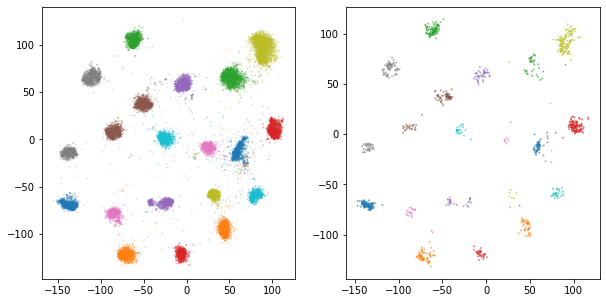

In [34]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=Y_train[:len(z)], cmap=plt.cm.tab10)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=Y_test, cmap=plt.cm.tab10)

### Save models + projections

In [35]:
import os

In [36]:
output_dir = MODEL_DIR/'projections'/ dataset / 'parametric-tsne'

In [37]:
encoder.save(os.path.join(output_dir, "encoder"))

I0720 10:52:25.764241 139722737252160 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins/parametric-tsne/encoder/assets


In [38]:
np.save(output_dir / 'z.npy', z)
np.save(output_dir / 'z_test.npy', z_test)

### compute metrics

#### silhouette

In [39]:
from tfumap.silhouette import silhouette_score_block

In [40]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.7423224333733186

In [41]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.7979687479843683

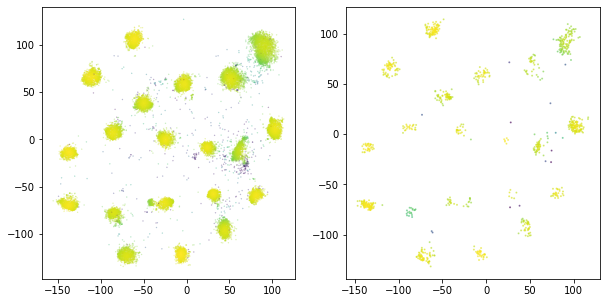

In [42]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.988

In [45]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.983

#### Trustworthiness

In [46]:
from sklearn.manifold import trustworthiness

In [47]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [51]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [52]:
tw, tw_test

(0.9856110568454763, 0.9845572580645161)

#### save output metrics

In [53]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,cassins,parametric-tsne,2,0.985611,0.742322,"[0.8330382289009316, 0.7695866976623688, 0.771..."


In [54]:
save_loc = DATA_DIR / 'projection_metrics' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [55]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,cassins,parametric-tsne,2,0.984557,0.797969,"[0.703768519535566, 0.8856849527900577, 0.8182..."


In [56]:
save_loc = DATA_DIR / 'projection_metrics' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [57]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['parametric-tsne', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,parametric-tsne,2,cassins,0.983,0.988


In [58]:
save_loc = DATA_DIR / 'knn_classifier' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)